In [ ]:
!/opt/bin/nvidia-smi

Tue Aug  9 13:50:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!unzip /content/traffic_data.zip

Archive:  /content/traffic_data.zip
   creating: traffic_data/
   creating: traffic_data/bus/
  inflating: traffic_data/bus/bus001.jpg  
  inflating: traffic_data/bus/bus002.jpg  
  inflating: traffic_data/bus/bus003.jpg  
  inflating: traffic_data/bus/bus004.jpg  
  inflating: traffic_data/bus/bus005.jpg  
  inflating: traffic_data/bus/bus006.jpg  
  inflating: traffic_data/bus/bus007.jpg  
  inflating: traffic_data/bus/bus008.jpg  
  inflating: traffic_data/bus/bus009.jpg  
  inflating: traffic_data/bus/bus010.jpg  
  inflating: traffic_data/bus/bus011.jpg  
  inflating: traffic_data/bus/bus012.jpg  
  inflating: traffic_data/bus/bus013.jpg  
  inflating: traffic_data/bus/bus014.jpg  
  inflating: traffic_data/bus/bus015.jpg  
  inflating: traffic_data/bus/bus016.jpg  
  inflating: traffic_data/bus/bus017.jpg  
  inflating: traffic_data/bus/bus018.jpg  
  inflating: traffic_data/bus/bus019.jpg  
  inflating: traffic_data/bus/bus020.jpg  
  inflating: traffic_data/bus/bus021.jpg  
  i

In [2]:
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import torchvision
from torchvision import transforms,datasets
from shutil import copy, rmtree
import json

In [3]:
def mk_file(file_path: str):
    if os.path.exists(file_path):
        rmtree(file_path)
    os.makedirs(file_path)
def split_data():
    split_rate = 0.25
    data_root = os.getcwd()
    origin_car_path = os.path.join(data_root, "traffic_data")
    assert os.path.exists(origin_car_path), "path '{}' does not exist.".format(origin_car_path)
    car_class = [cla for cla in os.listdir(origin_car_path) if os.path.isdir(os.path.join(origin_car_path, cla))]

  # 建立保存训练集的文件夹
    train_root = os.path.join(data_root, "train")
    mk_file(train_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(train_root, cla))

  # 建立保存验证集的文件夹
    test_root = os.path.join(data_root, "test")
    mk_file(test_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(test_root, cla))
    for cla in car_class:
        print(cla)
        cla_path = os.path.join(origin_car_path, cla)
        images = os.listdir(cla_path)
        num = len(images)
    # 随机采样验证集的索引
        eval_index = random.sample(images, k=int(num*split_rate))
        for index, image in enumerate(images):
            if image in eval_index:
      # 将分配至验证集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(test_root, cla)
                copy(image_path, new_path)
            else:
      # 将分配至训练集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(train_root, cla)
                copy(image_path, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
    print("processing done!")
split_data()

car
[car] processing [779/779]bus
[bus] processing [219/219]truck
[truck] processing [360/360]processing done!


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {"train": transforms.Compose([transforms.Resize((64,64)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),
(0.5,0.5,0.5))]),"test": transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])}


image_path = os.getcwd()
print(image_path)
train_dataset = datasets.ImageFolder(root=os.path.join(image_path,"train"),transform = data_transform["train"])
train_num = len(train_dataset)
print(train_num)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)

test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),transform = data_transform["test"])

test_num = len(test_dataset)
print(test_num)#val_num = 364
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,num_workers = 0)
print("using {} images for training, {} images for validation .".format(train_num,test_num))

using cuda:0 device.
/content
1019
338
using 1019 images for training, 338 images for validation .


In [5]:
#残差网络块
#每个残差块都是两层
#默认3*3卷积下padding为1，则大小不会变化，如变化则是步长引起的
class ResidualBlock(nn.Module):
  def __init__(self, nin, nout, size, stride=1, shortcut=True):
    super(ResidualBlock, self).__init__()
    #两层卷积层，不同步长只有第一层卷积层不同
    self.block1 = nn.Sequential(
        nn.Conv2d(nin, nout, size, stride, padding=1),
        nn.BatchNorm2d(nout),
        nn.ReLU(inplace=True),
        nn.Conv2d(nout, nout, size, 1, padding=1),
        nn.BatchNorm2d(nout)
        )
    self.shortcut = shortcut
    #解决通道数变化以及步长不为1引起的图片大小的变化
    self.block2 = nn.Sequential(
        nn.Conv2d(nin, nout, size, stride, 1),
        nn.BatchNorm2d(nout)
        )
    self.relu = nn.ReLU(inplace=True)  
  def forward(self, myinput):
    x = myinput
    out = self.block1(x)
    #若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道
    if self.shortcut:
      out = x + out
    else:
      out = out + self.block2(x)
    out = self.relu(out)
    return out

In [6]:
class resnet(nn.Module):
  def __init__(self):
    super(resnet, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(3, 64, 3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
        )
    #t表示2个相同的残差块,每个残差块两个卷积
    self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
    self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
    self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
    self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)
    self.avgp = nn.AvgPool2d(8)
    self.exit = nn.Linear(512, 3)
  def make_layer(self, in1, out1, ksize, stride, t):
    layers = []
    for i in range(0, t):
      if i == 0 and in1 != out1:
        layers.append(ResidualBlock(in1, out1, ksize, stride, None))
      else:
        layers.append(ResidualBlock(out1, out1, ksize, 1, True))
    return nn.Sequential(*layers)
  def forward(self, input):
    x = self.block(input)  #64 * 64 * 64    C * H * W
    x = self.d1(x)  # 64 * 54 * 54
    x = self.d2(x)  # 128 * 32 * 32
    x = self.d3(x)  # 256 * 16 * 16
    x = self.d4(x)  # 512 * 8 * 8
    x = self.avgp(x)  # 512 * 1 * 1
    x = x.squeeze()
    output = self.exit(x)
    return output

In [7]:
lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = resnet().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
  net.train() #指定当前为训练模式
  train_batch_num = len(data_loader) #记录共有多少个batch
  total_1oss = 0 #记录Loss
  correct = 0 #记录共有多少个样本被正确分类
  sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
  for batch_idx, (data,target) in enumerate (data_loader):
    t1 = time.time()
    #将图片放入指定的device中
    data = data.to(device).float()
    #将图片标签放入指定的device中
    target = target.to(device).long()
    #将当前梯度清零
    optimizer.zero_grad()
    #使用模型计算出结果
    output = net(data)
    #计算损失
    loss = loss_func(output, target.squeeze())
    #进行反向传播
    loss.backward()
    optimizer.step()
    #累加loss
    total_1oss += loss.item()
    #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
    prediction = torch.argmax(output, 1)
    #统计预测正确的类别数量
    correct += (prediction == target).sum().item()
    #累加当前的样本总数
    sample_num += len(prediction)
    #if batch_idx//5 ==0:
    t2 = time.time()
  #计算平均loss与准确率
  loss = total_1oss / train_batch_num
  acc = correct / sample_num
  return loss, acc

def test_epoch(net, data_loader, device):
  net.eval() #指定当前模式为测试模式
  test_batch_num = len(data_loader)
  total_loss = 0
  correct = 0
  sample_num = 0
  #指定不进行梯度变化
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader):
      data = data.to(device).float()
      target = target.to(device).long()
      output = net(data)
      loss = loss_func(output, target)
      total_loss += loss.item( )
      prediction = torch.argmax(output, 1)
      correct += (prediction == target).sum().item()
      sample_num += len(prediction)
  loss = total_loss / test_batch_num
  acc = correct / sample_num
  return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.time()
print(device)
#进行训练
for epoch in range(epochs):
  #每一个epoch的开始时间
  time_start = time.time()
  #在训练集上训练  
  train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
  #在测试集上验证
  test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
  #每一个epoch的结束时间
  time_end = (time.time() - time_start)
  #保存各个指际
  train_loss_list.append(train_loss)  
  train_acc_list.append(train_acc )  
  test_loss_list.append(test_loss)  
  test_acc_list.append(test_acc)  
  time_list.append(time_end)  
  print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.852564,test_loss 1.083717,train_acc 0.698724,test_acc 0.653846,Time used 12.006329s
epoch 2, train_loss 0.504858,test_loss 0.724183,train_acc 0.809617,test_acc 0.798817,Time used 4.821227s
epoch 3, train_loss 0.414161,test_loss 0.395238,train_acc 0.844946,test_acc 0.846154,Time used 4.610021s
epoch 4, train_loss 0.363396,test_loss 0.497016,train_acc 0.870461,test_acc 0.843195,Time used 4.571533s
epoch 5, train_loss 0.357817,test_loss 0.398669,train_acc 0.868499,test_acc 0.857988,Time used 4.620501s
epoch 6, train_loss 0.380820,test_loss 0.718739,train_acc 0.855741,test_acc 0.775148,Time used 4.613612s
epoch 7, train_loss 0.342769,test_loss 0.397511,train_acc 0.875368,test_acc 0.887574,Time used 4.633148s
epoch 8, train_loss 0.285020,test_loss 1.233628,train_acc 0.889107,test_acc 0.698225,Time used 4.610583s
epoch 9, train_loss 0.302535,test_loss 0.355742,train_acc 0.885182,test_acc 0.875740,Time used 4.669927s
epoch 10, train_loss 0.261965,test_loss 0.53071

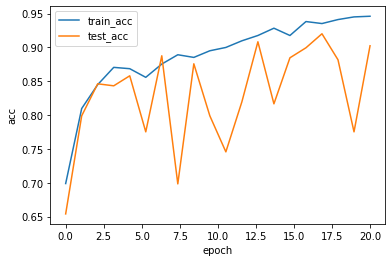

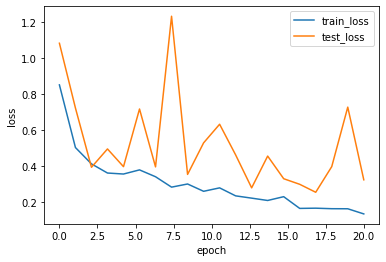

In [8]:
def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
  for i in args:
    x = np.linspace(0,len(i[0]),len(i[0]))
    plt.plot(x,i[0],label=i[1],linewidth=1.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()
Draw_Curve([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])

In [23]:
class DilatedResidualBlock(nn.Module):
  def __init__(self, nin, nout, size, stride=1, shortcut=True):
    super(DilatedResidualBlock, self).__init__()
      #两层卷积层
      #不同步长只有第一层卷积层不同
    self.block1 = nn.Sequential(
      nn.Conv2d(nin, nout, size, stride, padding=1, dilation=2), # (3-1)*2+1=5
      nn.BatchNorm2d(nout),
      nn.ReLU(inplace=True),
      nn.Conv2d(nout, nout, size, 1, padding=1, dilation=1),
      nn.BatchNorm2d(nout)
    )
    self.shortcut = shortcut
    #解决通道数变化以及步长不为1引起的图片大小的变化
    self.block2 = nn.Sequential(
      nn.Conv2d(nin, nout, size, stride, 1, dilation=2),
      nn.BatchNorm2d(nout)
    )
    self.relu = nn.ReLU(inplace=True)
  def forward(self, myinput):
    x = myinput
    out = self.block1(x)
    # print(x.size())
    # print(out.size())
    #若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道
    out = out + self.block2(x)
    out = self.relu(out)
    return out

In [27]:
class Dilatedresnet(nn.Module):
  def __init__(self):
    super(Dilatedresnet, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(3, 64, 3, stride=1, padding=1, dilation=2),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    #t表示2个相同的残差块,每个残差块两个卷积
    self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
    self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
    self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
    self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)
    self.avgp = nn.AvgPool2d(2)
    self.exit = nn.Linear(512, 3)
  def make_layer(self, in1, out1, ksize, stride, t):
    layers = []
    for i in range(0, t):
      if i == 0 and in1 != out1:
        layers.append(DilatedResidualBlock(in1, out1, ksize, stride, None))
      else:
        layers.append(DilatedResidualBlock(out1, out1, ksize, 1, True))
    return nn.Sequential(*layers)
  def forward(self, input):
    # print(input.size())
    x = self.block(input)  #64 * 64 * 64    C * H * W
    # print(x.size())
    x = self.d1(x)  # 64 * 54 * 54
    # print(x.size())
    x = self.d2(x)  # 128 * 32 * 32
    # print(x.size())
    x = self.d3(x)  # 256 * 16 * 16
    # print(x.size())
    x = self.d4(x)  # 512 * 8 * 8
    # print(x.size())
    x = self.avgp(x)  # 512 * 1 * 1
    # print(x.size())
    x = x.squeeze()
    output = self.exit(x)
    return output

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = Dilatedresnet().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
  net.train() #指定当前为训练模式
  train_batch_num = len(data_loader) #记录共有多少个batch
  total_1oss = 0 #记录Loss
  correct = 0 #记录共有多少个样本被正确分类
  sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
  for batch_idx, (data,target) in enumerate (data_loader):
    t1 = time.time()
    #将图片放入指定的device中
    data = data.to(device).float()
    #将图片标签放入指定的device中
    target = target.to(device).long()
    #将当前梯度清零
    optimizer.zero_grad()
    #使用模型计算出结果
    output = net(data)
    #计算损失
    loss = loss_func(output, target.squeeze())
    #进行反向传播
    loss.backward()
    optimizer.step()
    #累加loss
    total_1oss += loss.item()
    #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
    prediction = torch.argmax(output, 1)
    #统计预测正确的类别数量
    correct += (prediction == target).sum().item()
    #累加当前的样本总数
    sample_num += len(prediction)
    #if batch_idx//5 ==0:
    t2 = time.time()
  #计算平均loss与准确率
  loss = total_1oss / train_batch_num
  acc = correct / sample_num
  return loss, acc

def test_epoch(net, data_loader, device):
  net.eval() #指定当前模式为测试模式
  test_batch_num = len(data_loader)
  total_loss = 0
  correct = 0
  sample_num = 0
  #指定不进行梯度变化
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader):
      data = data.to(device).float()
      target = target.to(device).long()
      output = net(data)
      loss = loss_func(output, target)
      total_loss += loss.item( )
      prediction = torch.argmax(output, 1)
      correct += (prediction == target).sum().item()
      sample_num += len(prediction)
  loss = total_loss / test_batch_num
  acc = correct / sample_num
  return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_Dilatedresnet = []
train_acc_list_Dilatedresnet = []
test_loss_list_Dilatedresnet = []
test_acc_list_Dilatedresnet = []
time_list_Dilatedresnet = []
timestart_Dilatedresnet = time.time()
print(device)
#进行训练
for epoch in range(epochs):
  #每一个epoch的开始时间
  time_start = time.time()
  #在训练集上训练  
  train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
  #在测试集上验证
  test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
  #每一个epoch的结束时间
  time_end = (time.time() - time_start)
  #保存各个指际
  train_loss_list_Dilatedresnet.append(train_loss)  
  train_acc_list_Dilatedresnet.append(train_acc )  
  test_loss_list_Dilatedresnet.append(test_loss)  
  test_acc_list_Dilatedresnet.append(test_acc)  
  time_list_Dilatedresnet.append(time_end)  
  print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_Dilatedresnet)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.635920,test_loss 0.611044,train_acc 0.778214,test_acc 0.789941,Time used 5.780125s
epoch 2, train_loss 0.420149,test_loss 0.319998,train_acc 0.858685,test_acc 0.887574,Time used 5.456104s
epoch 3, train_loss 0.309195,test_loss 0.307695,train_acc 0.882237,test_acc 0.869822,Time used 5.457683s
epoch 4, train_loss 0.255385,test_loss 0.219721,train_acc 0.901865,test_acc 0.908284,Time used 5.448650s
epoch 5, train_loss 0.251727,test_loss 0.405511,train_acc 0.906771,test_acc 0.846154,Time used 5.488077s
epoch 6, train_loss 0.210231,test_loss 0.286753,train_acc 0.919529,test_acc 0.881657,Time used 5.496070s
epoch 7, train_loss 0.236803,test_loss 0.224542,train_acc 0.917566,test_acc 0.914201,Time used 5.520558s
epoch 8, train_loss 0.181181,test_loss 0.307497,train_acc 0.931305,test_acc 0.863905,Time used 5.518733s
epoch 9, train_loss 0.156924,test_loss 0.191722,train_acc 0.942100,test_acc 0.923077,Time used 5.470213s
epoch 10, train_loss 0.175879,test_loss 0.233741

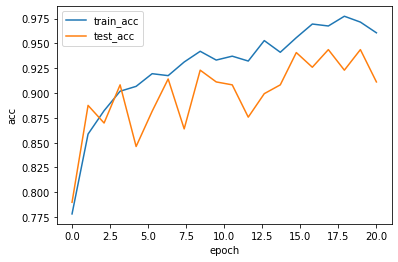

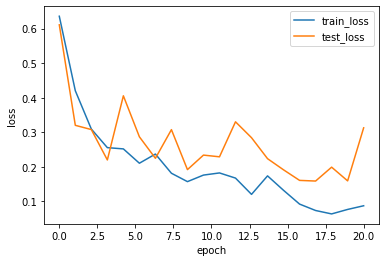

In [28]:
Draw_Curve([train_acc_list_Dilatedresnet,"train_acc"],[test_acc_list_Dilatedresnet,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_Dilatedresnet,"train_loss"],[test_loss_list_Dilatedresnet,"test_loss"])

In [15]:
for i in range(0, 2):
  print(i)

0
1
